Fitting a high dimsnsional dirichlet with ADVI yields a strange effect in the posterior for early itereations. Model can recover over iterations, but I think this means the prior is incorrect for the last member of the dirichlet.

There is no porblem when fitting with MCMC

In [86]:
import pymc3 as pm
import numpy as np
import pandas as pd

K=5

There are many divergences *only for the trace of the last member* when fitting with ADVI

Finished [100%]: Loss = 1.2539


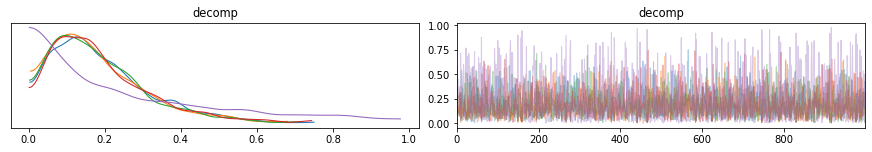

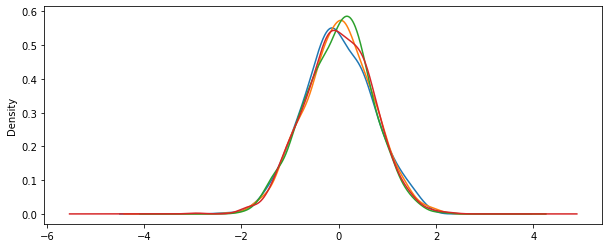

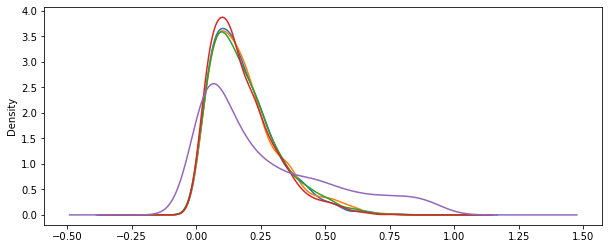

In [92]:
with pm.Model() as model:
    decomp = pm.Dirichlet('decomp', np.ones(K), shape=K)
    trace = pm.fit(1, method = 'advi')
    pm.plot_trace(trace.sample(1000), var_names = 'decomp');

pd.DataFrame(trace.sample(1000)['decomp_stickbreaking__']).plot.kde(figsize=(10,4), legend=False);
pd.DataFrame(trace.sample(1000)['decomp']).plot.kde(figsize=(10,4), legend = False);

If we reparameterize the dirichlet using a gamma distribution:  

$Y = [Y_1 \sim Gamma(\alpha_1, \theta), ..., Y_K \sim(Gamma(\alpha_K, \theta)]$  
$V = \sum_{i=1}^K Y_i \sim Gamma(\sum_{i=1}^K \alpha_i, \theta)$  
$X = [X_1, ..., X_K] = [\frac{Y_1}{V}, ..., \frac{Y_K}{V}] \sim Dir(\alpha_1, ..., \alpha_K)$

Note V is stochastically independent of X, even though the $X_i$'s are not independent.  
Since $\theta$ doesn't matter here, I set to 1.

Finished [100%]: Loss = 0.48711


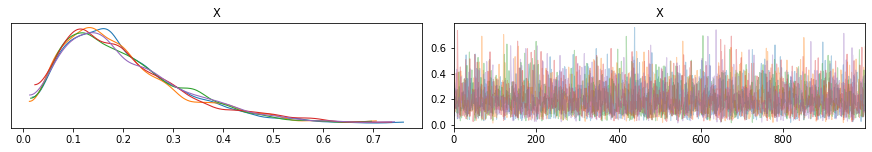

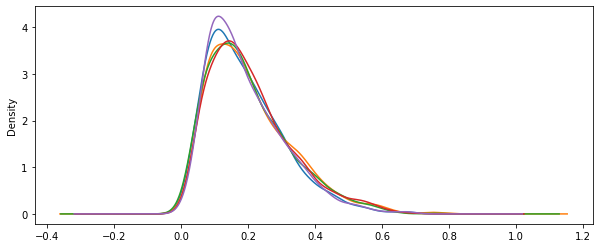

In [12]:
with pm.Model() as model:
    X = pm.math.stack([pm.Gamma(f'y_{k}', mu = 1, sigma = 1) for k in range(K)])
    X = pm.Deterministic('X', X/X.sum())
    trace = pm.fit(1, method = 'advi')
    pm.plot_trace(trace.sample(1000), var_names = 'X');

pd.DataFrame(trace.sample(1000)[X]).plot.kde(figsize=(10,4), legend = False);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [decomp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


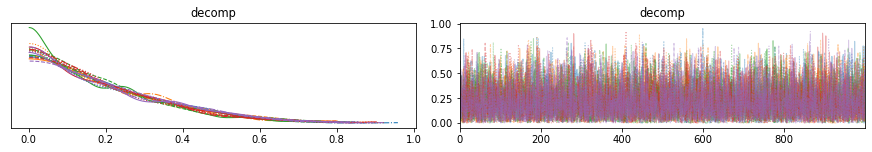

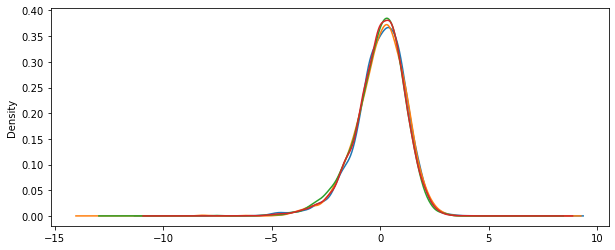

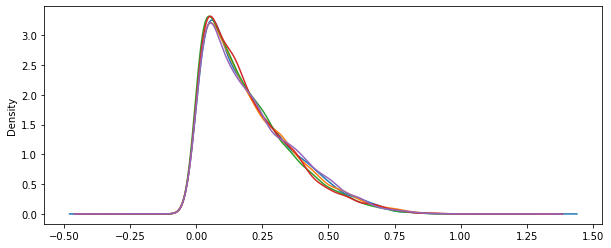

In [78]:
with pm.Model() as model:
    decomp = pm.Dirichlet('decomp', np.ones(D), shape=D)
    trace = pm.sample(1000, return_inferencedata=False)
    pm.plot_trace(trace, var_names = 'decomp');
       
pd.DataFrame(trace['decomp_stickbreaking__']).plot.kde(figsize=(10,4), legend=False);
pd.DataFrame(trace['decomp']).plot.kde(figsize=(10,4), legend=False);

An attempt to implement such that `shape`, `observed` and `testval` are usable

In [112]:
from utils import *
from plotting import *
from models import *
def load_counts(counts_fn, types_fn, type_subset=None):
    
    # probably don't want str input
    if isinstance(type_subset, str):
        warnings.warn("For str type_subset, each letter is matched. Are you sure you don't want list?", UserWarning)
        
    counts = pd.read_csv(counts_fn, index_col = [0], header = [0])[mut96]
    cancer_types = pd.read_csv(types_fn)
    cancer_types.columns=['type', 'guid']
    
    # subset guid by matching cancer type
    if type_subset is not None:
        
        # partial matches allowed
        sel = np.fromiter((map(any, zip(*[cancer_types.type.str.contains(x) for x in type_subset] ))), dtype = bool)
        
        # type should appear in the type column of the lookup 
        assert sel.any(), 'Cancer type subsetting yielded no selection. Check keywords?'
        
        counts = counts.loc[cancer_types.guid[sel]]

    return counts.to_numpy()

counts = load_counts('mutation_types_raw_counts.csv', 'pcawg_cancer_types.csv', ['Colo'])

In [137]:

counts

array([[  447,   954,    48, ...,  1435,   651, 31227],
       [  361,   230,    42, ...,   109,   130,   384],
       [  153,    81,    12, ...,    18,    38,    81],
       ...,
       [  632,   381,    49, ...,   171,   266,  1176],
       [  290,   214,    21, ...,   169,   171,   832],
       [  498,   230,    32, ...,   122,   113,  1052]])

In [122]:
def init_kmeans(data=None, J=None, K=None):
    return {'phi': kmeans_alr(data, J, get_phis),
            'eta': kmeans_alr(data, K, get_etas).reshape(-1,2,3)} 

init = init_kmeans(counts, J, K)

In [123]:
plot_phi(init['phi'])

In [155]:
def ch_dirichlet(node_name, a, shape, scale=1, testval = None):
    X = pm.Gamma(f'gamma_{node_name}', mu = a, sigma = scale, shape = shape, testval = testval)
    X = pm.Deterministic(node_name, (X/X.sum(axis = 1)[:,None]))
    return X


In [168]:
beta = np.ones((K,4)) * np.array([2,1,1,1])
beta[:,[0,2,3]]
beta = np.ones(4) * np.array([2,1,1,1])
beta[[0,2,3]]

array([2., 1., 1.])

In [176]:
import theano.tensor as tt

J=2
C=3
K = 5
M=3
alpha_bias = np.array([1,2,0.5])
init_phi = np.array([[0.2, 0.3, 0.5], [0.9, 0.05, 0.05]])
beta = np.ones(4) * np.array([2,0.5,1,1])

with pm.Model() as model:
    phi = pm.Dirichlet('phi', a = np.ones(C) * alpha_bias, shape=(J, C), testval = init_phi)
    tt.printing.Print()(phi)
    g = pm.Gamma(f'g', mu = 1, sigma = 1, shape = (1,K,M))
    tt.printing.Print()(g)
    e = ch_dirichlet('e', np.ones(C) * alpha_bias, (J,C), testval = init_phi)
    tt.printing.Print()(e)
    etaC = ch_dirichlet("etaC", a=beta[[0,2,3]], shape=(K, M))
    etaT = ch_dirichlet("etaT", a=beta[[0,1,2]], shape=(K, M))
    tt.printing.Print()(etaC)
    tt.printing.Print()(etaT)
    eta = pm.Deterministic('eta', pm.math.stack([etaC, etaT], axis=1))
    tt.printing.Print()(eta[1])

 __str__ = [[0.2  0.3  0.5 ]
 [0.9  0.05 0.05]]
 __str__ = [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
 __str__ = [[0.2  0.3  0.5 ]
 [0.9  0.05 0.05]]
 __str__ = [[0.5  0.25 0.25]
 [0.5  0.25 0.25]
 [0.5  0.25 0.25]
 [0.5  0.25 0.25]
 [0.5  0.25 0.25]]
 __str__ = [[0.57142857 0.14285714 0.28571429]
 [0.57142857 0.14285714 0.28571429]
 [0.57142857 0.14285714 0.28571429]
 [0.57142857 0.14285714 0.28571429]
 [0.57142857 0.14285714 0.28571429]]
 __str__ = [[0.5        0.25       0.25      ]
 [0.57142857 0.14285714 0.28571429]]
